# Import Dependencies 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from keras.models import Sequential
import itertools 
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [3]:
#Load EEG data as Power Spectrum Density Representation

path = '/MyPath/'

X_train = np.load(path + "x_trainp.npy")


X_test = np.load(path + "x_testp.npy")

print(X_train.shape, X_test.shape)

(8640, 63, 125, 1) (2880, 63, 125, 1)


In [4]:
#Load Mel Spectrograms of Music Stimuli

path = '/MyPath/'

y_train = np.load(path + "y_train3.npy")


y_test = np.load(path + "y_test3.npy")

print(y_train.shape, y_test.shape)

(8640, 44, 128) (2880, 44, 128)


In [5]:
#Shuffle Train indices to stabilize training 

train_idx = np.random.permutation(X_train.shape[0])
X_train = np.take(X_train,train_idx,axis=0)
y_train = np.take(y_train,train_idx,axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


(0.0, 63.0)

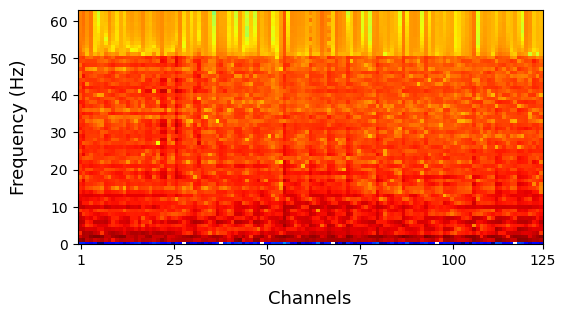

In [7]:
#Plot EEG

font = {'family': 'DejaVu Sans', 
        'color':  'black', 
        'size': 13, 
        } 

idx = 9

y = np.reshape(X_train[idx], (63,125))
y = 20*np.log10(y)
plt.figure(dpi=100)
plt.imshow(y, cmap='jet')
plt.ylabel('Frequency (Hz)', fontdict=font, labelpad=16)
plt.xlabel('Channels', fontdict=font, labelpad=16)
plt.xticks([0.5,25.5,50.5,75.5,100.5,124.5],['1','25','50','75','100','125'])
plt.ylim([0, 63])

[Text(0.5, 1.0, 'Mel Spec')]

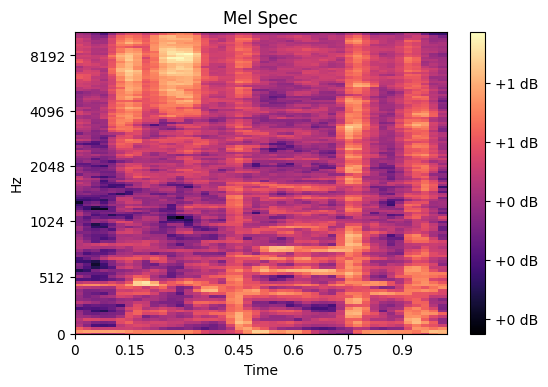

In [9]:
#Plot Music Mel Spectrograms

import librosa.display
SR = 22050

fig, ax = plt.subplots(dpi=100)
img = librosa.display.specshow(y_train[idx].T,cmap='magma', x_axis='time', y_axis='mel', ax=ax, sr=SR, hop_length=int(512))
fig.colorbar(img, ax=ax,format="%+2.f dB")
ax.set(title='Mel Spec')

# Define Model & Train

In [10]:
#set dimensions for model target reshape
rows = y_train.shape[1]
cols = y_train.shape[2]

In [11]:
#Define the Hyperparameters 

kernel_init = keras.initializers.he_uniform(seed=1369)
kernel_reg = keras.regularizers.l2(0.000001)
act_reg = keras.regularizers.l2(0.0000001)
k = 4 #Kernel Size
p = 2 #Pool Size
f = 8 #Number of Filters

#Define Mish and Swish activation functions to test whether it works better than ReLu
def mish(x):
   return x * keras.backend.tanh(keras.backend.softplus(x))

from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
#get_custom_objects().update({'swish': Activation(swish)})
get_custom_objects().update({'mish': Activation(mish)})

#Set Activation function
my_act = 'relu'

In [12]:
from keras.models import *
import tensorflow as tf
from tensorflow.keras import Model
##########################################MODEL#############################################################
batches = 60 #model training batch size
input_layer = keras.Input(shape = (X_train.shape[1], X_train.shape[2], 1), batch_size=(batches))

x = layers.ZeroPadding2D()(input_layer)
x = layers.Conv2D(kernel_size=(k,k),filters=f,activation=my_act,kernel_initializer=kernel_init,
                        padding="same")(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(kernel_size=(k,k),filters=f*2,activation=my_act,kernel_initializer=kernel_init,
                        padding="same")(x)
#x = layers.ZeroPadding2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(kernel_size=(k,k),filters=f*4,activation=my_act,kernel_initializer=kernel_init,
                        padding="same")(x)
#x = layers.ZeroPadding2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(kernel_size=(k,k),filters=f*8,activation=my_act,kernel_initializer=kernel_init,
                        padding="same")(x)
#x = layers.ZeroPadding2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(kernel_size=(k,k),strides=(2,2),filters=f*16,activation=my_act,kernel_initializer=kernel_init,
                        padding="same")(x)
x = layers.ZeroPadding2D()(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(pool_size=(p,p))(x)

x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.1)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)#2

x = layers.Dense(128, activation=my_act,kernel_initializer=kernel_init)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)#3
x = layers.Dense(128, activation=my_act,kernel_initializer=kernel_init)(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.1)(x)

x = layers.Dense(rows*cols, activation='linear')(x)
x = layers.Reshape((rows, cols))(x)


model = Model(input_layer, [x], name='M1')

model.summary()

Model: "M1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(60, 63, 125, 1)]        0         
                                                                 
 conv2d (Conv2D)             (60, 63, 125, 8)          136       
                                                                 
 batch_normalization (BatchN  (60, 63, 125, 8)         32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (60, 63, 125, 8)          0         
                                                                 
 conv2d_1 (Conv2D)           (60, 63, 125, 16)         2064      
                                                                 
 batch_normalization_1 (Batc  (60, 63, 125, 16)        64        
 hNormalization)                                                

In [13]:
opt = keras.optimizers.Adam(learning_rate=0.0015)
model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=opt,metrics=tf.keras.metrics.MeanSquaredError())
history = model.fit(X_train,y_train,epochs=200,validation_data=(X_test,y_test),batch_size=batches)

Epoch 1/200
144/144 [==============================] - 21s 51ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0571 - val_mean_squared_error: 0.0571
Epoch 2/200
144/144 [==============================] - 7s 47ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/200
144/144 [==============================] - 7s 47ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 4/200
144/144 [==============================] - 7s 47ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 5/200
144/144 [==============================] - 7s 47ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 6/200
144/144 [==============================] - 7s 47ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 7/200
144

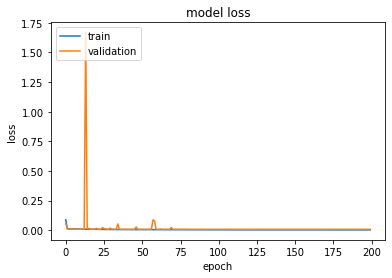

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate Model Outputs

In [15]:
out = model.predict(X_test)

print(out.shape)

(2880, 44, 128)


[Text(0.5, 1.0, 'Mel Spec')]

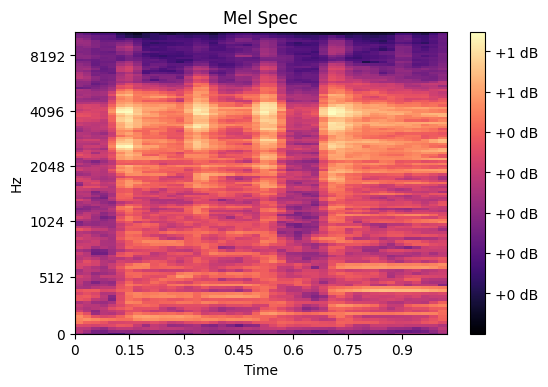

In [30]:
########STIMULI########
idx = 20

SR = 22050

fig, ax = plt.subplots(dpi=100)
img = librosa.display.specshow(y_test[idx].T,cmap='magma', x_axis='time', y_axis='mel', ax=ax, sr=SR, hop_length=int(512))
fig.colorbar(img, ax=ax,format="%+2.f dB")
ax.set(title='Mel Spec')

[Text(0.5, 1.0, 'Mel Spec')]

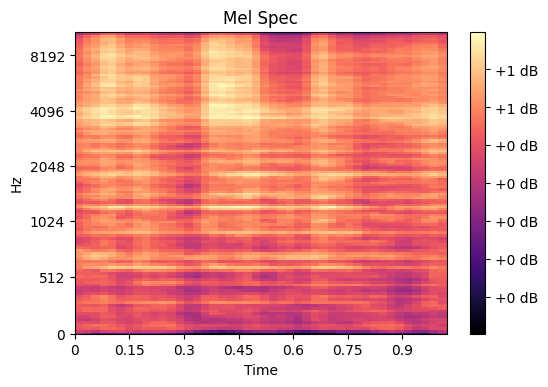

In [31]:
########MEL RECONSTRUCTION########
fig, ax = plt.subplots(dpi=100)
img = librosa.display.specshow(out[idx].T,cmap='magma', x_axis='time', y_axis='mel', ax=ax, sr=SR, hop_length=int(512))
fig.colorbar(img, ax=ax,format="%+2.f dB")
ax.set(title='Mel Spec')

In [32]:
#INVERSION#
max_db = 100
ref_db = 46

mel = y_test[idx].T
mel = (np.clip(mel, 0, 1) * max_db) - max_db + ref_db
x = librosa.feature.inverse.mel_to_audio(mel)


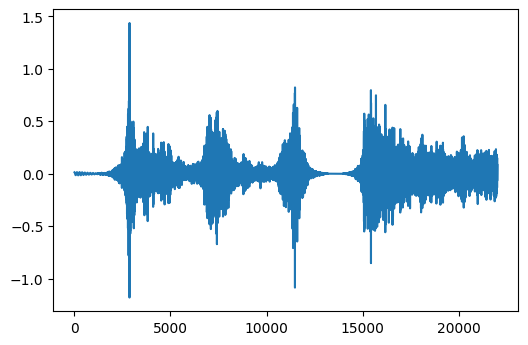

In [33]:
####STIMULI WAVEFORM####
plt.figure(dpi=100)
plt.plot(x)

In [34]:
#INVERSION#
max_db = 100
ref_db = 46

mel = out[idx].T
mel = (np.clip(mel, 0, 1) * max_db) - max_db + ref_db
x = librosa.feature.inverse.mel_to_audio(mel)


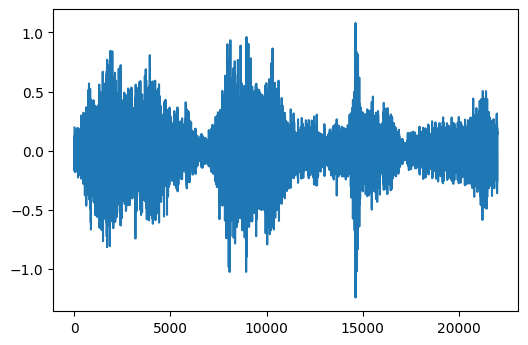

In [35]:
####RECONSTRUCTION WAVEFORM####
plt.figure(dpi=100)
plt.plot(x)